# Rotation Broadening

## Import Necessary Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tardis.io.atom_data.util import download_atom_data

from stardis.base import run_stardis
from scipy.ndimage import gaussian_filter1d

from astropy import units as u, constants as const

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

## Download Atomic Data

STARDIS contains a post-simulation function to broaden the spectrum appropriate for a v sin(i) given by the user. However, this is only physically valid when the spectrum broadened is given over a small range of frequencies or wavelengths, or is constant in velocity resolution across the spectrum. We also need to know the velocity per pixel of the spectrum. 

First, let's run a small, simple STARDIS simulation sampled every 0.01 $\AA$, then convolve it to a spectral resolution $R \sim 100000$

In [2]:
tracing_lambdas = np.arange(6540, 6590, 0.01) * u.Angstrom

sim = run_stardis('rotation_broadening_config.yml', tracing_lambdas) #This just uses a solar MARCS model with 30 elements and 10 thetas.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


$R = \lambda / \Delta \lambda$

$100000 = 6550 \AA / \Delta \lambda$

$\Delta \lambda = .065 \AA$, which is 6.5 pixels and the FWHM of the Gaussian. We need sigma in pixel space, so then divide by 2.355 for FWHM to standard deviation, and then by .01 for the pixel size.

In [3]:
fwhm = .065 / .01
fwhm

6.5

In [4]:
sigma = fwhm / 2.355 
sigma

2.760084925690021

So we can broaden the stardis spectrum to our target $R$ by convolving it with a Gaussian with our found sigma.

In [5]:
instrumental_spec = gaussian_filter1d(sim.spectrum_lambda, sigma=sigma)

Now, let's use the STARDIS broadening function and compare the outputs.

In [6]:
from stardis.radiation_field.opacities.opacities_solvers import rotation_broadening

Calculate the velocity resolution of the spectrum using $V = c / R$

In [7]:
v = const.c.to(u.km/u.s) / 100000
v

<Quantity 2.99792458 km / s>

And finally we need the velocity per pixel of the simulated instrumental spectrum. If v is the velocity resolution of the spectrum, which corresponds to the pixels spanned by the FWHM, we can divide v by that FWHM to get the velocity per pixel. 

In [8]:
vel_per_pix = v / fwhm 
vel_per_pix

<Quantity 0.46121917 km / s>

And then let's apply the rotation broadening for our spectrum with a rotation velocity of 20 km/s.

In [9]:
wave, broadened_flux = rotation_broadening(vel_per_pix, sim.lambdas, instrumental_spec, v_rot = 20 * u.km/u.s)

## Plot spectra

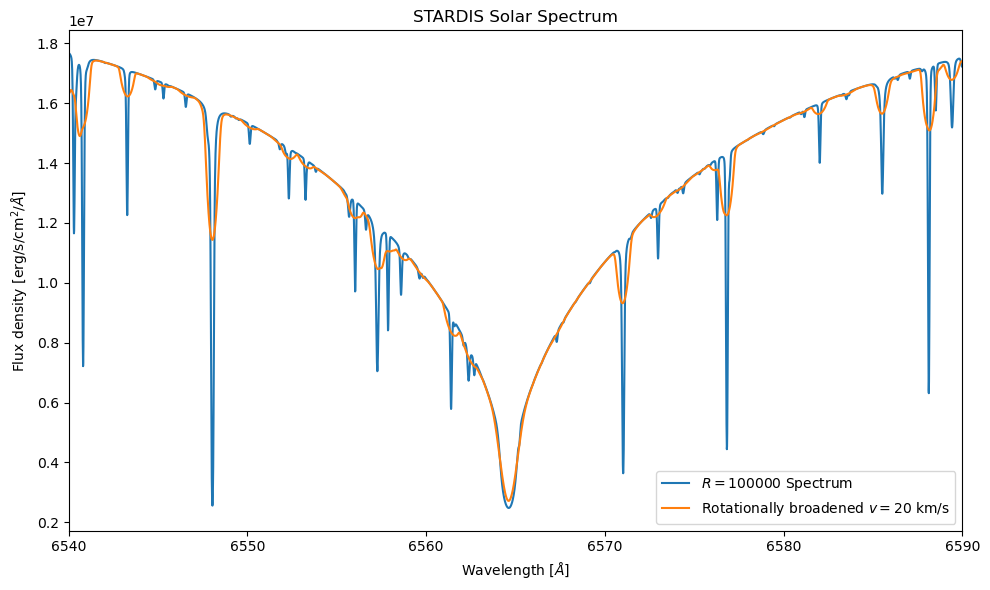

In [10]:
plt.figure(figsize=(10,6))
plt.plot(sim.lambdas, instrumental_spec, label=f'$R = 100000$ Spectrum')
plt.plot(wave, broadened_flux, label=f'Rotationally broadened $v = 20$ km/s')

plt.xlim((6540,6590))
plt.title("STARDIS Solar Spectrum")
plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel(r"Flux density [erg/s/cm$^2$/$\AA$]")
plt.tight_layout()

plt.legend()
plt.show()